# Task 1: Linear Regression model

We have taken the Real estate valuation data set from UCI repository. We have split the X values to be the following columns: 'X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude'. We have then split the data into training and testing sets after which we have standardized the data.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance


# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

X = X[['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']]

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

Before modeling, we must see if any of the input variables correlate with each other. There should be no multicolinearity.

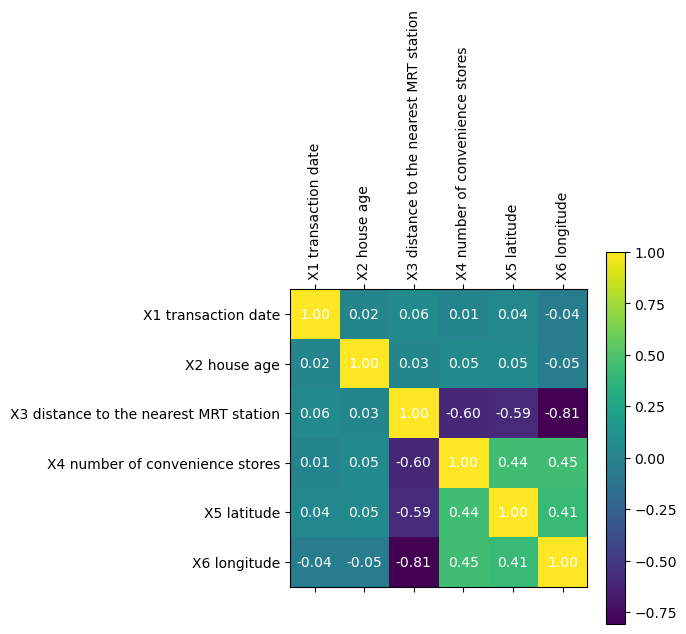

In [26]:
# Correlation heatmap of the features
plt.matshow(X.corr())
plt.colorbar()
plt.xticks(range(X.shape[1]), X.columns, rotation=90)
plt.yticks(range(X.shape[1]), X.columns)
# give me numbers on the heatmap
for (i, j), corr in np.ndenumerate(X.corr()):
    plt.text(j, i, f'{corr:.2f}', ha='center', va='center', color='white')
plt.show()

We remove coordinates from the data because they are obviously unnecessary and lead to overfitting.

In [27]:
# Remove coordinates
X_train_scaled = np.delete(X_train_scaled, [4, 5], axis=1)
X_test_scaled = np.delete(X_test_scaled, [4, 5], axis=1)

Here we train a Linear Regression model from the training data.

In [28]:
# Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
# accuracy
print(f'R^2 score: {r2_score(y_test, y_pred)}')


R^2 score: 0.6383424573403562


We then plot the features against the house price of unit area to see more information about them.

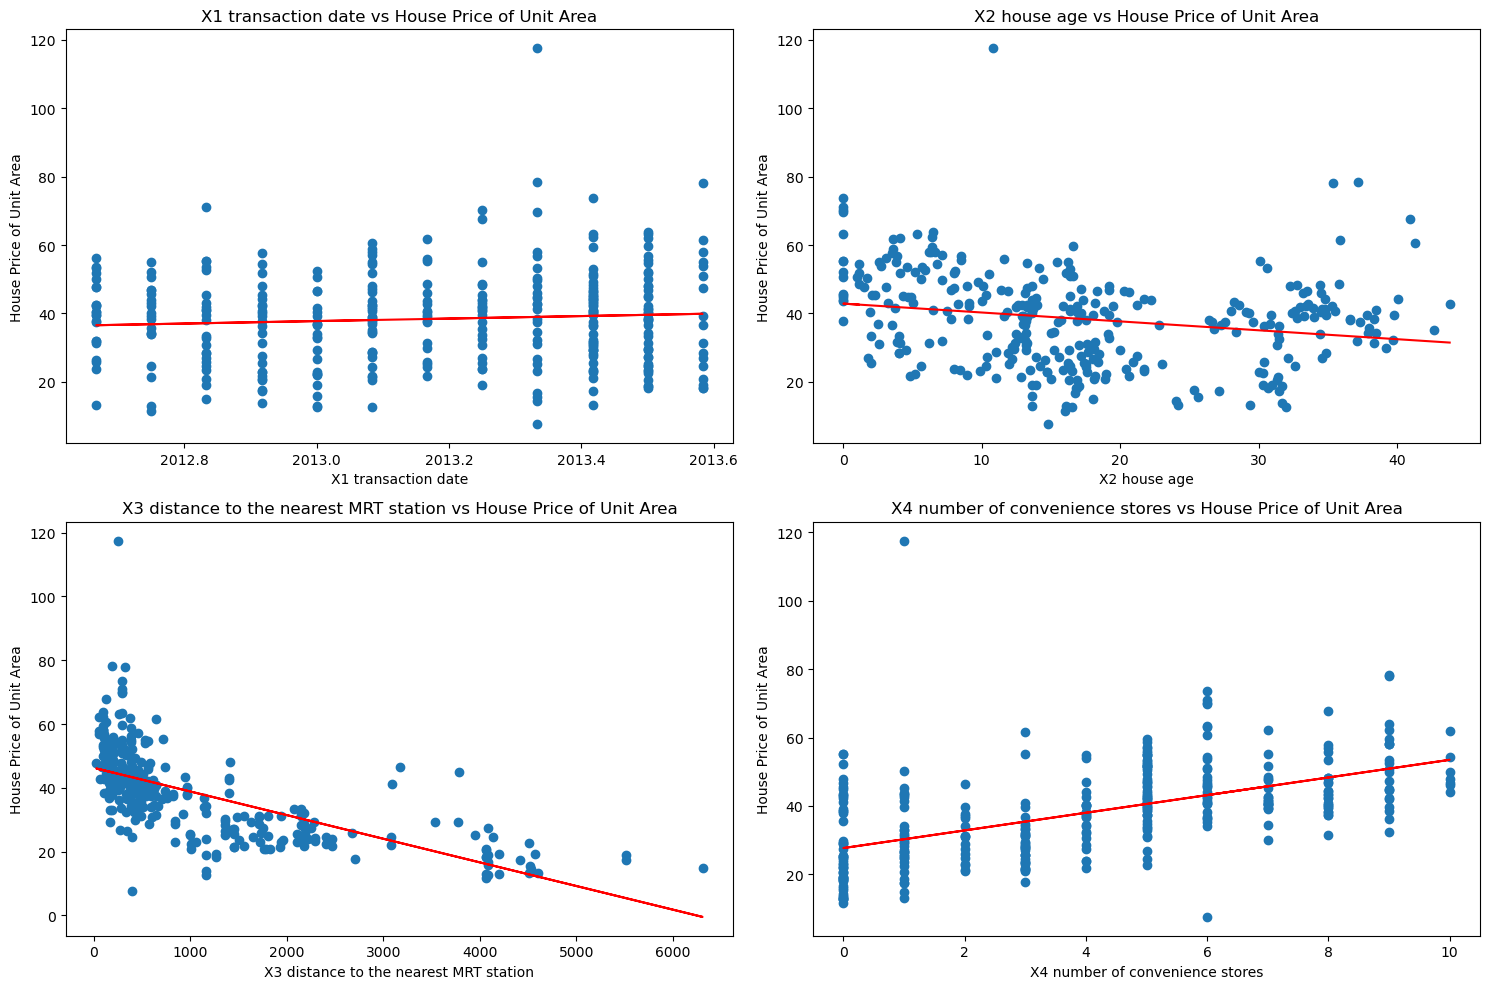

In [29]:
# List of features to plot
features = ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    axes[i].scatter(X_train[feature], y_train)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('House Price of Unit Area')
    trendline = np.polyfit(X_train[feature], y_train, 1)
    axes[i].plot(X_train[feature], trendline[1] + trendline[0] * X_train[feature], color='red')
    axes[i].set_title(f'{feature} vs House Price of Unit Area')
    

plt.tight_layout()
plt.show()

Here we see each feature plotted against the house price of unit area. We can see that the number of convenience stores has a positive correlation with the house price of unit area. The distance to the nearest metro station has a negative correlation with the house price of unit area. The other features show less clear correlation with the house price of unit area, with house age being a small negative correlation.

In [30]:
b0 = model.intercept_
b1, b2, b3, b4= model.coef_[0]
print("Intercept:", b0)
print("Coefficients:")
print("X1 transaction date:", b1)
print("X2 house age:", b2)
print("X3 distance to the nearest MRT station:", b3)
print("X4 number of convenience stores:", b4)

Intercept: [38.39154079]
Coefficients:
X1 transaction date: 1.622536003967538
X2 house age: -2.9262924277689253
X3 distance to the nearest MRT station: -6.832910242212365
X4 number of convenience stores: 3.6291165616123755


We then plot the predictions against the actual values. The red dashed line represents the ideal fit where the predicted values are equal to the actual values. The closer the points are to the red dashed line, the better the model.

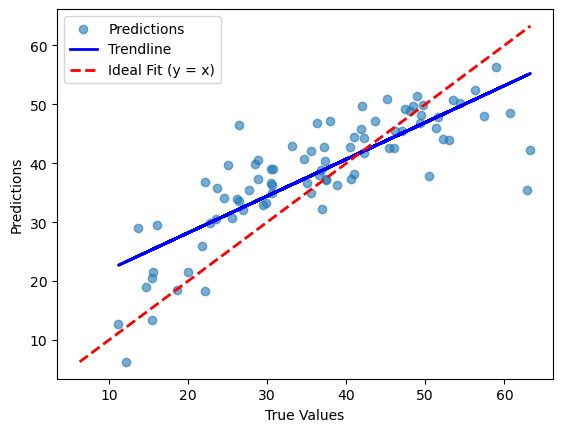

In [31]:
# Convert y_test to a NumPy array if it's a Pandas DataFrame
y_test_array = y_test.to_numpy().flatten()
y_pred_array = y_pred.flatten()  # Ensure it's a 1D NumPy array

# Scatter plot of predictions vs actual values
plt.scatter(y_test_array, y_pred_array, label='Predictions', alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Add a trendline (linear regression line)
coefficients = np.polyfit(y_test_array, y_pred_array, 1)
poly = np.poly1d(coefficients)
trendline = poly(y_test_array)

plt.plot(y_test_array, trendline, color='blue', linestyle='-', linewidth=2, label="Trendline")

# Add a y=x line for perfect prediction
min_val = min(y_test_array.min(), y_pred_array.min())
max_val = max(y_test_array.max(), y_pred_array.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed', linewidth=2, label="Ideal Fit (y = x)")

plt.legend()
plt.show()

Voit pysähtyä tähän katselemaan yllä olevaa kuvaa hetkeksi. Jatka notebookin lukua, kun olet valmis.

We then evaluate the Linear Regression model using the mean absolute error, mean squared error, and R2 score.

In [32]:
# Evaluation of Linear Regression
print("Linear Regression Metrics:")
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

Linear Regression Metrics:
Mean Absolute Error: 5.94653335915373
Mean Squared Error: 60.67157696040314
R2 Score: 0.6383424573403562


### Task 2: Logistic regression

In [33]:
average_price = y.mean()
binary_y = y > average_price.astype(int) # Convert to binary, with 0 being below average and 1 being above average

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, binary_y, test_size=0.2, random_state=42)

# Train
model = LogisticRegression()
model.fit(X_train, y_train.astype(int).values.ravel())

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Logistic Regression Metrics:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

# Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()


Logistic Regression Metrics:
Accuracy: 0.8433734939759037
Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.77      0.84        43
        True       0.79      0.93      0.85        40

    accuracy                           0.84        83
   macro avg       0.85      0.85      0.84        83
weighted avg       0.85      0.84      0.84        83

Confusion Matrix:
[[33 10]
 [ 3 37]]


Looks like our model is performing fairly well. It seems to be worse at recognizing expensive houses.

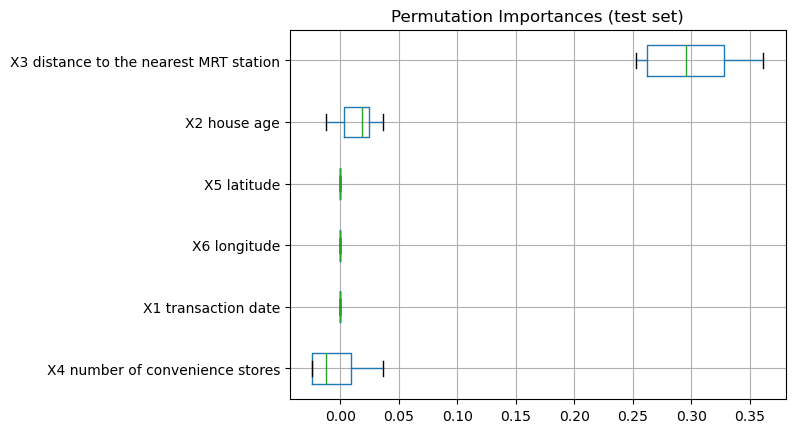

In [36]:
permutation_importance_df = pd.DataFrame(result.importances[sorted_idx].T, columns=X.columns[sorted_idx])
permutation_importance_df.boxplot(vert=False)
plt.title('Permutation Importances (test set)')
plt.show()

The most important metrics are still distance to the nearest metro station, with house price and store number being less important. Transaction date and house coordinates are still next to meaningless.
Here we did not prune the coordinates out of the model before training.
In a real-world application I would either trim the coordinates out, or change them so that they are instead distances to some points of interest in the world, such as big cities.